In [55]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd

In [56]:
data_dir = Path("Desktop/CTC/")

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(",")[0] for img in images]
#print(labels)
characters = set(char for label in labels for char in label)

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width =260
img_height =35

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any prescription in the dataset
max_length = max([len(label) for label in labels])
labels = [label.ljust(max_length) for label in labels]

Number of images found:  529
Number of labels found:  529
Number of unique characters:  40
Characters present:  {'(', 's', ' ', 'f', 'z', 'p', 'q', 'g', 'd', 't', 'b', 'o', 'c', '3', 'n', 'j', 'v', '8', 'a', 'w', 'x', ')', '9', 'i', '7', '4', 'y', '0', '2', '1', 'u', 'h', 'e', 'l', 'r', 'm', '6', '5', '-', 'k'}


In [57]:
# Mapping characters to integers
char_to_num = layers.experimental.preprocessing.StringLookup(
    vocabulary=list(characters), num_oov_indices=0, mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    #print(indices[5])
    if shuffle:
         np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))
#print(x_train,y_train)


def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

In [58]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
#print(train_dataset)
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

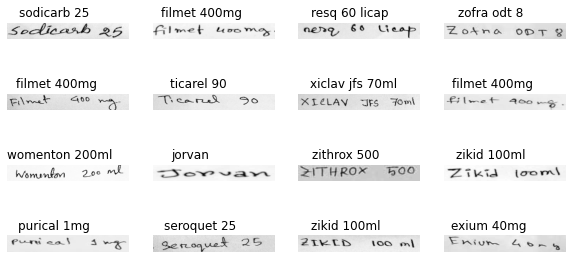

In [59]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
#print(train_dataset.take(1))
for batch in train_dataset.take(1):
    #print(batch)
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        #ax[i // 4, i % 4].imshow(img[:, :, 0], cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [60]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred
    
#temp =img_width
#img_width=img_height
#img_height=temp


def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
        #shape=(img_height,img_width,  1), name="image", dtype="float32"
    
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv0",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool0")(x)
    
    
    
    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)
    
    
     # First conv block
    grb=''''x = layers.Conv2D(
            32,
            (3, 3),
            activation="relu",
            kernel_initializer="he_normal",
            padding="same",
            name="Conv",
        )(x)'''
    #x = layers.MaxPooling2D((2, 2), name="pool")(x)
    

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)
    
   

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 8), (img_height // 8) * 64)
    #new_shape = ((img_height // 8)*64, (img_width // 8) )
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(len(characters) + 1, activation="softmax", name="dense2")(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
#model.summary()

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [61]:
epochs = 120
early_stopping_patience = 15
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/120
30/30 [==============================] - 9s 287ms/step - loss: 55.4248 - val_loss: 47.5697
Epoch 2/120
30/30 [==============================] - 7s 221ms/step - loss: 43.6364 - val_loss: 41.9762
Epoch 3/120
30/30 [==============================] - 7s 218ms/step - loss: 40.6804 - val_loss: 40.2490
Epoch 4/120
30/30 [==============================] - 6s 216ms/step - loss: 39.3711 - val_loss: 39.5087
Epoch 5/120
30/30 [==============================] - 7s 226ms/step - loss: 38.4584 - val_loss: 38.7862
Epoch 6/120
30/30 [==============================] - 7s 218ms/step - loss: 37.6537 - val_loss: 38.1398
Epoch 7/120
30/30 [==============================] - 7s 224ms/step - loss: 36.9760 - val_loss: 37.5359
Epoch 8/120
30/30 [==============================] - 7s 219ms/step - loss: 36.4846 - val_loss: 37.1614
Epoch 9/120
30/30 [==============================] - 7s 220ms/step - loss: 35.9991 - val_loss: 36.6107
Epoch 10/120
30/30 [==============================] - 7s 219ms/step - los

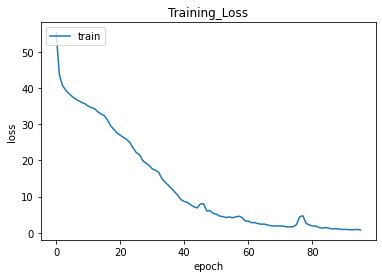

In [62]:
history.history.keys()
plt.plot(history.history["loss"])
plt.title("Training_Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train"],loc="upper left")
plt.show()

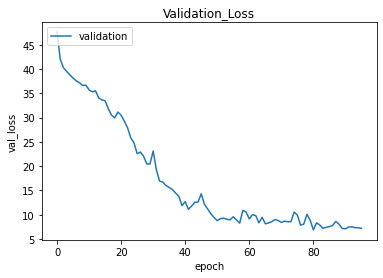

In [63]:
plt.plot(history.history["val_loss"])
plt.title("Validation_Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.legend(["validation"],loc="upper left")
plt.show()

In [64]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    
    deco=float(keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[1][0][0])
    
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    #accuracys  =[]
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return (output_text,deco)


#  Let's check results on some validation samples
y_pred=[]
y_grnd=[]
total_accuracy=0
pres_accuracy=0
for batch in validation_dataset.take(3):
    batch_images = batch["image"]
    #print(batch_images[0])
   
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts,acc = decode_batch_predictions(preds)
    #print(acc)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)
        
    
    for i in range(len(pred_texts)):
        pred_texts[i]=pred_texts[i].split("[UNK]")[0]
        if len(pred_texts[i]) < 18:
            cnt_=18-len(pred_texts[i])
            for j in range(cnt_):
                pred_texts[i]=pred_texts[i]+" "
                
       
   
    
    for i in range(len(pred_texts)):
        
        prd_txt=pred_texts[i]
        grnd_txt=orig_texts[i].split("  ")[0]
        c_num=0;
        for itr,val in enumerate(grnd_txt):
            #print(val,grnd_txt[itr])
            if val==prd_txt[itr]:
                c_num+=1
            
        accuracy=int((100*c_num)/len(grnd_txt))
        
        if accuracy == 100:
            pres_accuracy=pres_accuracy+1
        
        total_accuracy=total_accuracy+accuracy
        #print(c_num,len(grnd_txt),grnd_txt,prd_txt.split("[UNK]")[0])
        #if i==1:
           # break
            
        int_orig=char_to_num(tf.strings.unicode_split(orig_texts[i], input_encoding="UTF-8"))
        int_orig=tf.Variable(int_orig).numpy().tolist()
        int_pred=char_to_num(tf.strings.unicode_split(pred_texts[i], input_encoding="UTF-8"))
        int_pred=tf.Variable(int_pred).numpy().tolist()
        for temp in int_orig:
            y_grnd.append(temp)
        for temp in int_pred:
            y_pred.append(temp)
            
        #y_grnd=y_grnd+char_to_num(tf.strings.unicode_split(orig_texts[i], input_encoding="UTF-8"))
        print("Original_text:",grnd_txt,"   predicted_text:",prd_txt.split("  ")[0],"  accuracy:",accuracy,"%")
        
prescription_accuracy=(pres_accuracy*100)/(3*len(pred_texts))

total_accuracy=total_accuracy/(3*len(pred_texts))
print("\n")
print("Total_character_Accuracy:==> ",total_accuracy,"%")
print("Presciption_accuracy:==>",prescription_accuracy,"%")

Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 260, 35, 1)]      0         
_________________________________________________________________
Conv0 (Conv2D)               (None, 260, 35, 32)       320       
_________________________________________________________________
pool0 (MaxPooling2D)         (None, 130, 17, 32)       0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 130, 17, 32)       9248      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 65, 8, 32)         0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 65, 8, 64)         18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 32, 4, 64)       

In [65]:
class_names=['0', 'k', 'h', 'q', '6', 'w', '7', ' ', 'v', 'y', 
             '5', 'b', 'n', 'g', 'p', 'c', 'r', 'm', 'x', 'z', 'u', 'o', 't', '-',
             'f', '1', 'i', '4', ')', '9', 'l', '8', 'a', 'e', '3', 'j', '2', 'd', '(', 's']
#len(class_names)


C:\Users\admin\.conda\envs\tf\lib\site-packages\mlxtend\plotting\plot_confusion_matrix.py:76: RuntimeWarning: invalid value encountered in true_divide
  normed_conf_mat = conf_mat.astype('float') / total_samples


(<Figure size 864x864 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

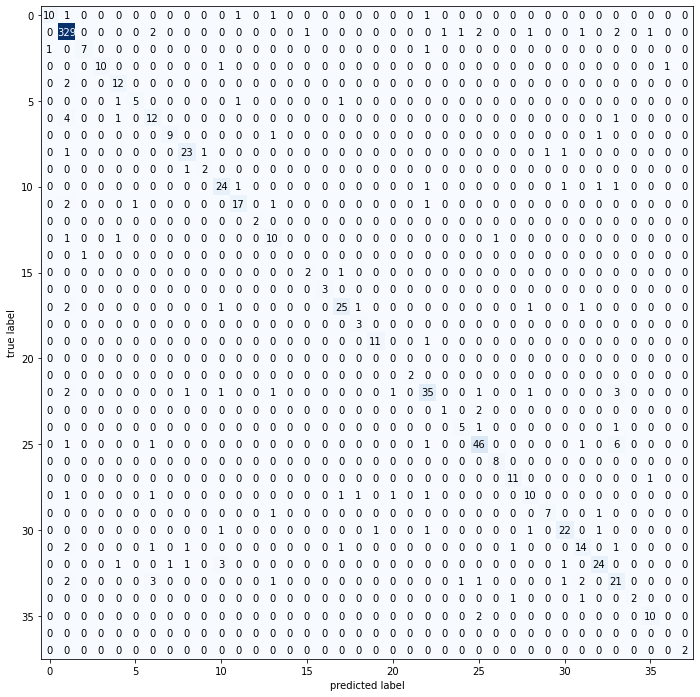

In [69]:



from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
mat=confusion_matrix(y_grnd,y_pred)
plot_confusion_matrix(conf_mat=mat,figsize=(12,12))

In [70]:
class_names=['0', 'p', '3', '6', 'h', '7', 'u', 'i', 'd', 's', '9', 'n', 'x', 'w', '1', '8', '-', 'g', 'l', 'e', 'c',' ',
              '4', 'a', 'y', 'r', 't', 'b', 'o', 'q', 'z', 'k', 'v', 'j', 'f', '2', '5', 'm']

from sklearn.metrics import classification_report
print(classification_report(y_grnd, y_pred, target_names=class_names))

              precision    recall  f1-score   support

           0       0.91      0.71      0.80        14
           p       0.94      0.96      0.95       341
           3       0.88      0.78      0.82         9
           6       1.00      0.83      0.91        12
           h       0.75      0.86      0.80        14
           7       0.83      0.62      0.71         8
           u       0.60      0.67      0.63        18
           i       0.90      0.82      0.86        11
           d       0.85      0.85      0.85        27
           s       0.67      0.67      0.67         3
           9       0.77      0.83      0.80        29
           n       0.85      0.77      0.81        22
           x       1.00      1.00      1.00         2
           w       0.62      0.77      0.69        13
           1       0.00      0.00      0.00         1
           8       0.67      0.67      0.67         3
           -       1.00      1.00      1.00         3
           g       0.86    

C:\Users\admin\.conda\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\.conda\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\.conda\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\admin\.conda\envs\tf\lib\site-packages\